In [1]:
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy

dats_mod=["CMCC-CESM","CMCC-CM","CNRM-CM5",
          "CanESM2","GFDL-CM3","GFDL-ESM2M",
          "HadCM3","HadGEM2-CC","IPSL-CM5A",
          "MIROC-ESM","MIROC5","MPI-ESM-MR",
          "MRI-CGCM3","MRI-ESM1","NorESM1-M"]
base_dir="/global/cscratch1/sd/marielp"
#Make a summary frame for differences
summ_frame=pd.DataFrame()
xpt=200
ypt=40

In [2]:
#Examine the averages
flist=[]


for d in dats_mod:
    f="{:}/{:}/{:}_1980_2005_avg.nc".format(base_dir,d,d)
    flist.append(f)


darr_list=[]
for f in flist:
    fopen=xa.open_dataset(f,decode_times=False)
    darr_list.append(fopen)

In [3]:
#initialize a dataset for the model average
#Make a model average
new_lons = np.arange(0.,360.)
new_lats=np.arange(-90.,91.)


model_avg=xa.Dataset(coords={"lat":new_lats,"lon":new_lons})

In [4]:
def daynum_to_date(nday,strcalendar):
    if (strcalendar=="360_day"):
        mn=int(nday/30)
        dn=nday%30
        if (dn==0):
            return(mn,30)
        else:
            return(mn+1,dn)
    else:
        num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
        d_copy= nday
        for m in range(0,len(num_days)):
            dprev=d_copy
            d_copy=d_copy-num_days[m]
            if (d_copy<0):
                break
        return(m+1,dprev)   
    

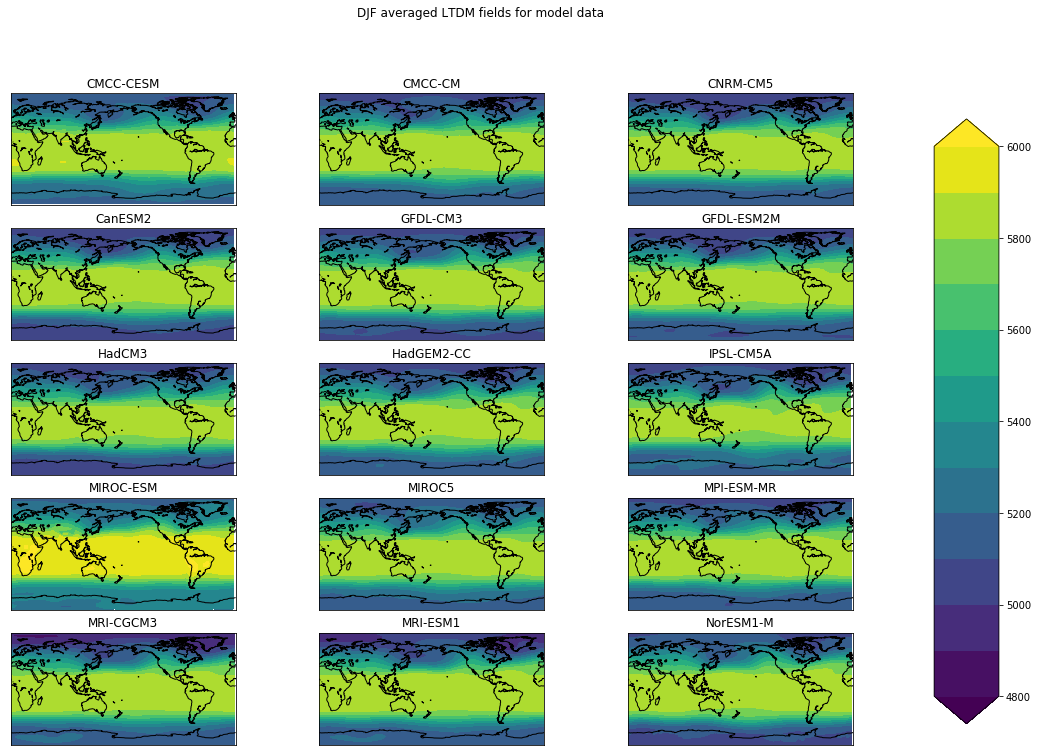

In [5]:
#Now we'll make plots of the averaged values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
c_breaks=np.arange(4800,6100,100)
dict_avgval={}

fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged LTDM fields for model data")
num_dats = len(darr_list)
model_avg['modelAvgMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])
for i in range(5):
    for j in range(3):
        d_curr=darr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))
        v_mean=d_curr['AZ500'][drange,:,:].mean(dim='time')
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        dict_avgval[dats_mod[dc]]=v_mean_interp.sel(lat=ypt,lon=xpt,method='nearest').item(0)
        model_avg['modelAvgMean']+=(v_mean_interp.values/15.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(d_curr.lon.values,d_curr.lat.values,
                         v_mean.values,c_breaks,extend='both')
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the DJF averages for the LTDM field of the 15 models. 

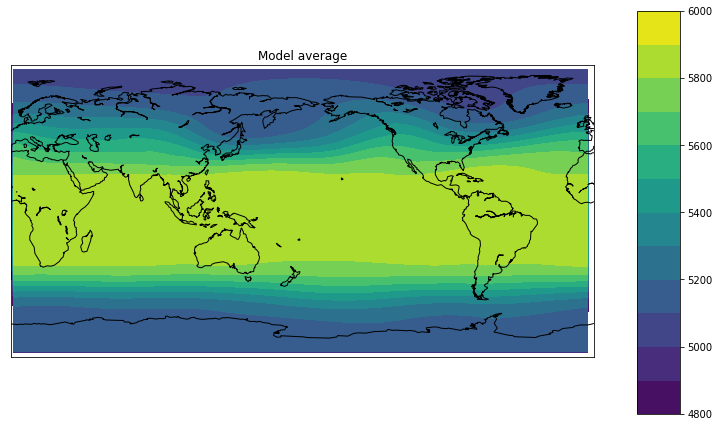

In [6]:
#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Model average")
im = ax.contourf(model_avg.lon.values,model_avg.lat.values,model_avg.modelAvgMean.values,c_breaks)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

In [7]:
s=pd.Series(dict_avgval)
s.name="avg"
summ_frame=summ_frame.append(s)

This is the multi-model average (note that the longitude axis edges do not quite match up due to edge interpolation issues-- I'm trying to figure out if there's a way to do a periodic interpolation)

KeyError: 'reanAvgMean'

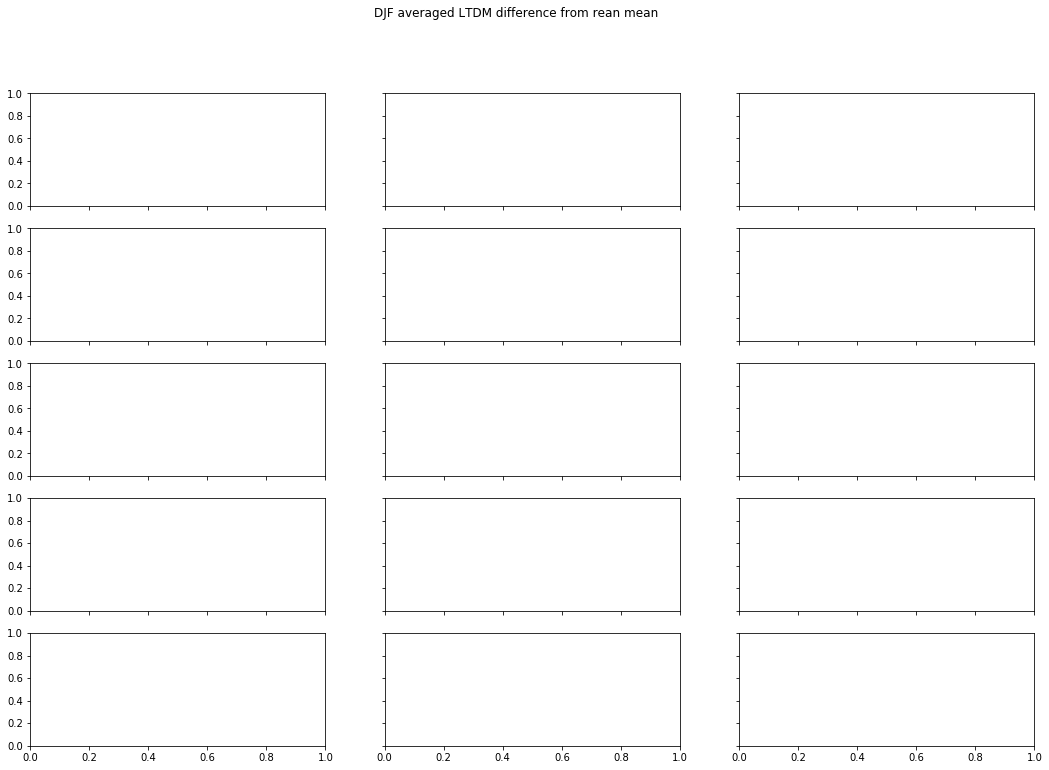

In [5]:
#The deviation from the model average
dc=0
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
diff_breaks=np.arange(-150,160,10)

fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged LTDM difference from model mean")
num_dats = len(darr_list)
dict_avgd={}
for i in range(5):
    for j in range(3):
        d_curr=darr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))
        v_mean=d_curr['AZ500'][drange,:,:].mean(dim='time')
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        v_diff = v_mean_interp - model_avg['modelAvgMean'].values
        dict_avgd[dats_mod[dc]]=v_diff.sel(lat=ypt,lon=xpt,method='nearest').item(0)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(model_avg.lon.values,model_avg.lat.values,
                         v_diff.values,diff_breaks,extend="both",cmap="bwr")
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

In [9]:
s=pd.Series(dict_avgd)
s.name="avgdev"
summ_frame=summ_frame.append(s)

These are the individual model differences from the multi-model mean for the LTDM. MIROC-ESM sticks out rather prominently-- the Z500 values are quite a bit higher than the model average across the entire map. There's a mix of positive and negative deviations from the mean. 

In [8]:
#Plots of the threshold figures for DJF
flist=[]
for d in dats_mod:
    f="{:}/{:}/{:}_1980_2005_thresh.nc".format(base_dir,d,d)
    flist.append(f)

tarr_list=[]
for f in flist:
    fopen=xa.open_dataset(f,decode_times=False)
    tarr_list.append(fopen)

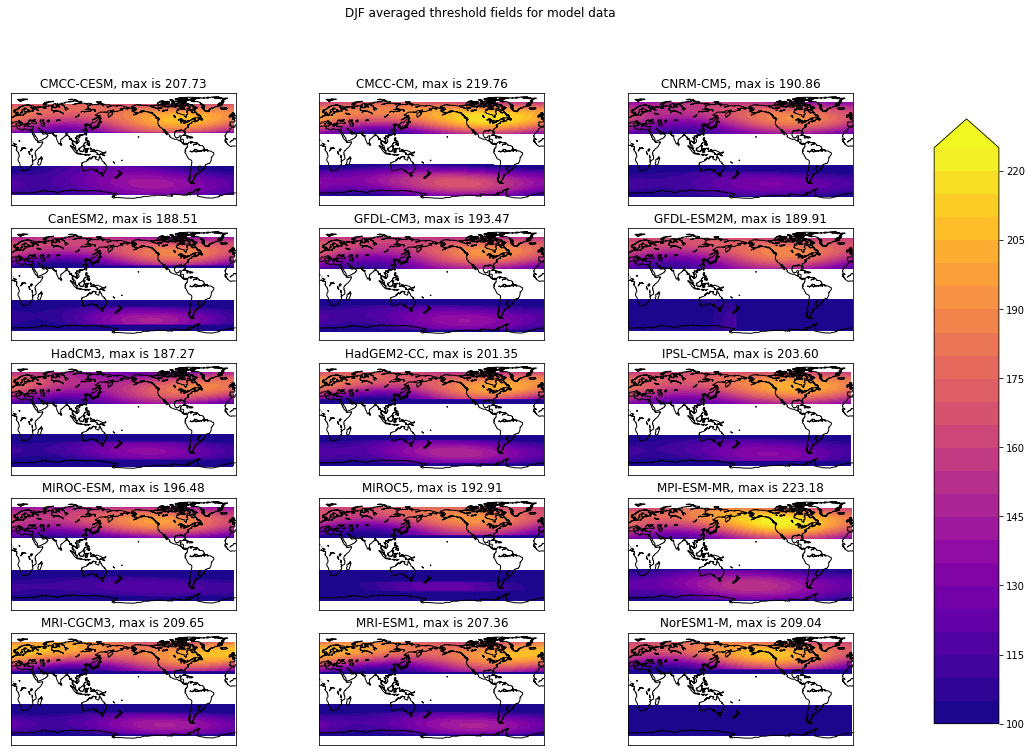

In [11]:
#Now we'll make plots of the averaged values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
t_breaks=np.arange(100,230,5)

fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged threshold fields for model data")
model_avg['modelThreshMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])
dict_thresh={}
for i in range(5):
    for j in range(3):
        d_curr=tarr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))

        v_mean=d_curr['THRESHOLD_DFT'][drange,:,:].mean(dim='time') 
        v_mean[np.where(v_mean<100)]=100.01
        vmax=v_mean.max().values
        v_mean_nh=v_mean.sel(lat=slice(25,75))
        v_mean_sh=v_mean.sel(lat=slice(-75,-25))
        v_mean_0 = v_mean.sel(lat=slice(-24.9,24.9))
        v_mean_0.values = np.zeros(v_mean_0.shape)
        v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
        v_mean_rev_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        dict_thresh[dats_mod[dc]]=v_mean_rev_interp.sel(lat=ypt,lon=xpt,method='nearest').item(0)

        model_avg['modelThreshMean']+=(v_mean_rev_interp.values/15.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}, max is {:.2f}".format(dats_mod[dc],vmax))
        im=ax[i,j].contourf(v_mean_rev.lon.values,v_mean_rev.lat.values,
                         v_mean_rev.values,t_breaks,extend='max',cmap="plasma")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the DJF-averaged thresholds for the models.

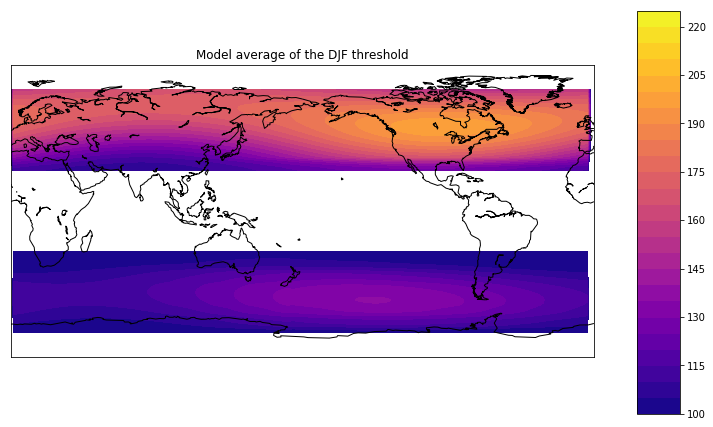

In [15]:

#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Model average of the DJF threshold")
model_thresh=model_avg.modelThreshMean
v_mean_nh=model_thresh.sel(lat=slice(25,75))
v_mean_sh=model_thresh.sel(lat=slice(-75,-25))
v_mean_0 = model_thresh.sel(lat=slice(-24.9,24.9))
v_mean_0.values = np.zeros(v_mean_0.shape)
v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
im = ax.contourf(v_mean_rev.lon.values,v_mean_rev.lat.values,v_mean_rev.values,t_breaks,cmap="plasma")
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

In [13]:
s=pd.Series(dict_thresh)
s.name="thresh"
summ_frame=summ_frame.append(s)

This the multi-model average for the threshold. The averaged pattern looks very similar to the one seen in the paper, which is rather unsurprising, but some, like NorESM1-M and MPI-ESM-MR have a pattern max that extends out into the Pacific. 

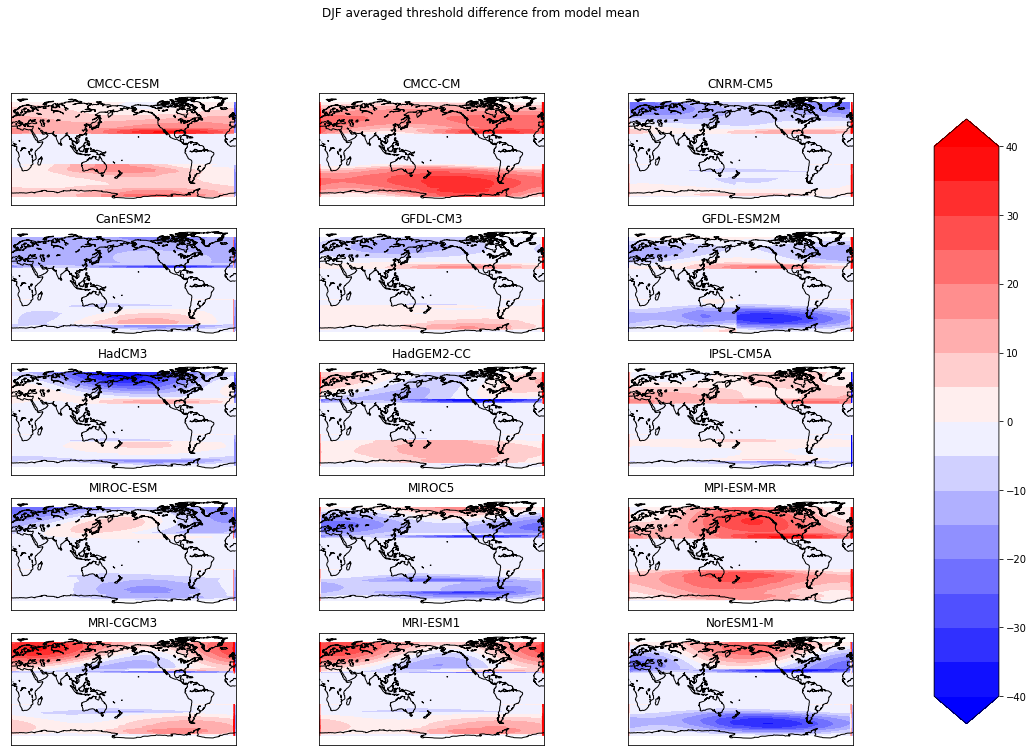

In [22]:
#difference plot for threshold values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
dt_breaks=np.arange(-40,45,5)

fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged threshold difference from model mean")
dict_threshd={}
for i in range(5):
    for j in range(3):
        d_curr=tarr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))

        v_mean=d_curr['THRESHOLD_DFT'][drange,:,:].mean(dim='time') 
        v_mean[np.where(v_mean<100)]=100.01
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        v_diff = v_mean_interp-model_avg['modelThreshMean']
        v_mean_nh=v_diff.sel(lat=slice(26,75))
        v_mean_sh=v_diff.sel(lat=slice(-75,-24))
        v_mean_0 = v_diff.sel(lat=slice(-25,25))
        v_mean_0.values = np.zeros(v_mean_0.shape)
        v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
        dict_threshd[dats_mod[dc]]=v_diff.sel(lat=ypt,lon=xpt,method='nearest').item(0)

        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(v_mean_rev.lon.values,v_mean_rev.lat.values,
                         v_mean_rev.values,dt_breaks,extend='both',cmap="bwr")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the threshold differences from the model mean threshold. There is a difference that maxes out at about 50 meters (and something weird going on with GFDL-ESM2M that I can't figure out, because the file looks fine in ncview). The red/blue lines at the edges are again an artifact of interpolation. 

In [15]:
s=pd.Series(dict_threshd)
s.name="threshdev"
summ_frame=summ_frame.append(s)

In [16]:
#Examine the blocking frequency
flist_blobs={}
for d in dats_mod:
    f_glob=sorted(glob.glob("{:}/{:}/BLOBS_NOREGIONAL/{:}*DJF_blobs_noregional.nc".format(base_dir,d,d)))
    flist_blobs[d] = f_glob
                  

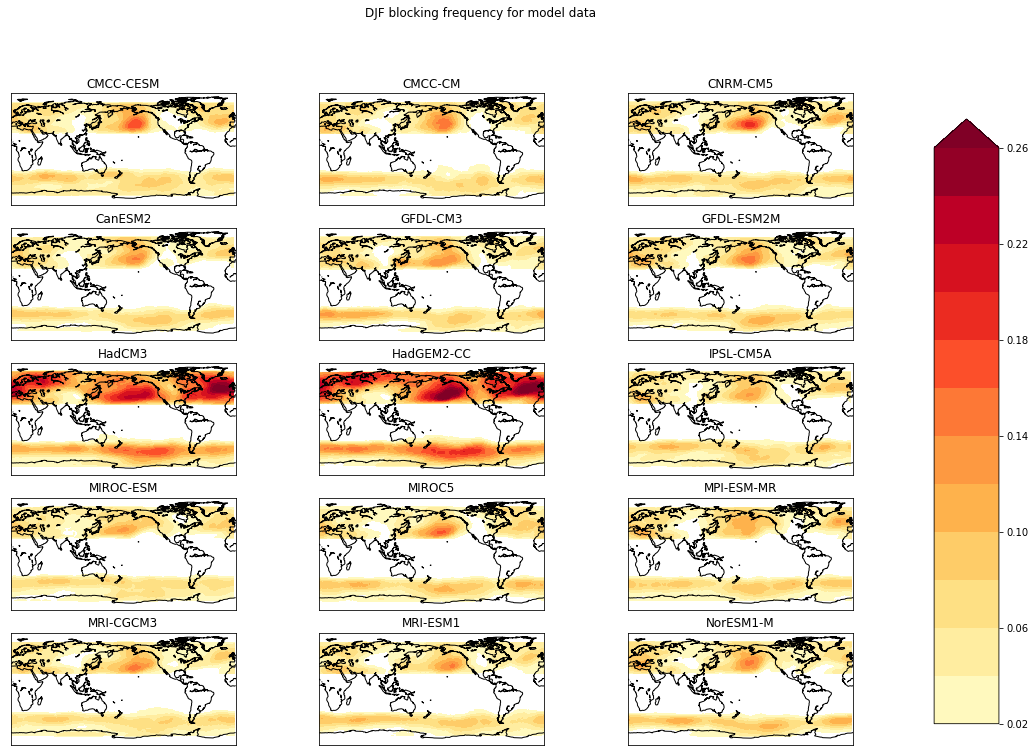

In [17]:
#Now we're plotting the blocking frequency
dc=0
b_breaks=np.arange(0.02,0.28,0.02)
model_avg['modelBlockMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF blocking frequency for model data")
dict_freq={}
for i in range(5):
    for j in range(3):
        dcurr=flist_blobs[dats_mod[dc]]
        d_mf = xa.open_mfdataset(dcurr)
        b_avg = d_mf['Z_BLOB'].mean(dim='time')
        b_avg_interp = b_avg.interp(lat=new_lats,lon=new_lons).fillna(0)
        dict_freq[dats_mod[dc]]=b_avg_interp.sel(lat=ypt,lon=xpt,method='nearest').values[()]

        model_avg['modelBlockMean']+=(b_avg_interp.values/15.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(b_avg.lon.values,b_avg.lat.values,
                         b_avg.values,b_breaks,extend='max',cmap="YlOrRd")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

I have ABSOLUTELY no idea what the heck is up with the Hadley Center data-- there's about 50% more blocking going on. I need to check the logs and make sure nothing went wonky in the calculation process. The fact that it's a 360-day calendar rather than a 365-day calendar means there might be a bug that I haven't caught.

Most of the models have a negative difference with regards to the model average in the NH, but I wonder how that would change once I check the Hadley data.

In [18]:
s=pd.Series(dict_freq)
s.name="freq"
summ_frame=summ_frame.append(s)

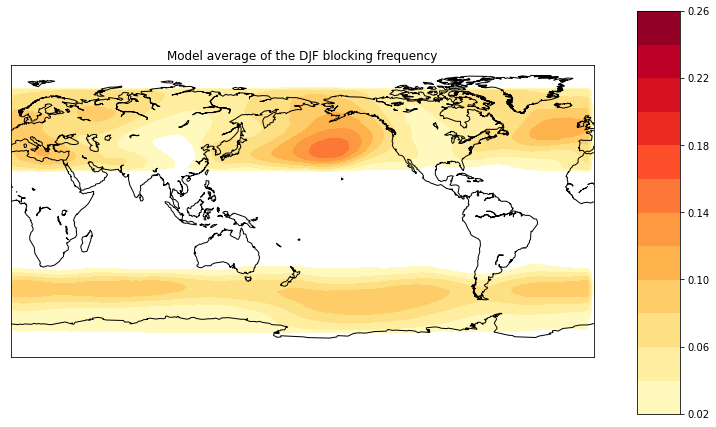

In [19]:

#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Model average of the DJF blocking frequency")
im = ax.contourf(model_avg.lon.values,model_avg.lat.values,model_avg.modelBlockMean.values,b_breaks,cmap="YlOrRd")
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

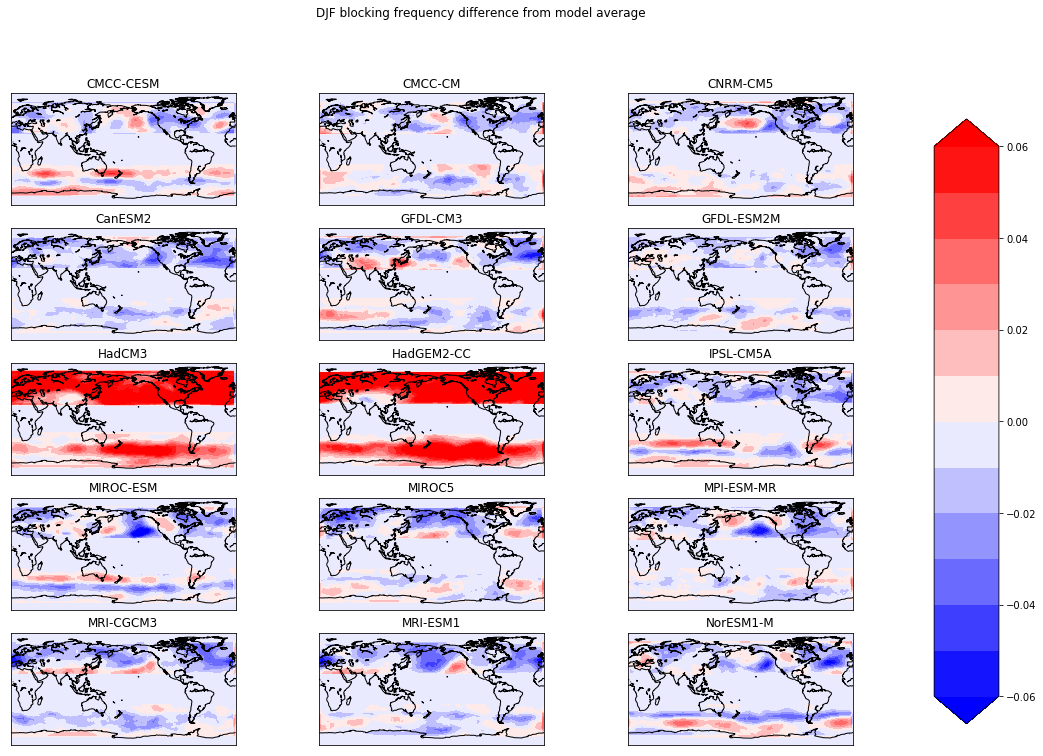

In [20]:
#Now we're plotting the blocking frequency
dc=0
bd_breaks=np.arange(-0.06,0.07,0.01)
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF blocking frequency difference from model average")
dict_freqd={}
for i in range(5):
    for j in range(3):
        dcurr=flist_blobs[dats_mod[dc]]
        d_mf = xa.open_mfdataset(dcurr)
        b_avg = d_mf['Z_BLOB'].mean(dim='time')
        b_avg_interp = b_avg.interp(lat=new_lats,lon=new_lons).fillna(0)
        b_diff = b_avg_interp-model_avg.modelBlockMean.values
        dict_freqd[dats_mod[dc]]=b_diff.sel(lat=ypt,lon=xpt,method='nearest').values[()]
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(model_avg.lon.values,model_avg.lat.values,
                         b_diff.values,bd_breaks,extend='both',cmap="bwr")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

The blocking stats and the reanalysis version of this report will be forthcoming. Stay tuned!

In [21]:
s=pd.Series(dict_freqd)
s.name="freqdev"
summ_frame=summ_frame.append(s)

In [22]:
summ_frame

,CMCC-CESM,CMCC-CM,CNRM-CM5,CanESM2,GFDL-CM3,GFDL-ESM2M,HadCM3,HadGEM2-CC,IPSL-CM5A,MIROC-ESM,MIROC5,MPI-ESM-MR,MRI-CGCM3,MRI-ESM1,NorESM1-M
avg,5486.076685,5443.740022,5463.204718,5448.202867,5356.338672,5408.148100,5408.764326,5464.290926,5337.706410,5649.479193,5455.059269,5517.619366,5321.676781,5309.510677,5493.041490
avgdev,48.552718,6.216056,25.680751,10.678900,-81.185294,-29.375867,-28.759641,26.766960,-99.817557,211.955226,17.535302,80.095399,-115.847186,-128.013290,55.517523
thresh,182.767345,185.768757,163.580727,160.179024,165.746111,169.564957,159.031733,161.869957,173.239877,172.012921,160.649483,196.138138,156.183219,154.098857,175.296387
threshdev,13.692179,16.693591,-5.494439,-8.896142,-3.329055,0.489791,-10.043433,-7.205209,4.164711,2.937754,-8.425683,27.062972,-12.891947,-14.976309,6.221221
freq,0.177725,0.148132,0.189663,0.142705,0.124556,0.144358,0.214222,0.287889,0.118765,0.100871,0.150820,0.107129,0.130123,0.121110,0.139556
freqdev,0.024550,-0.005043,0.036488,-0.010470,-0.028619,-0.008817,0.061047,0.134714,-0.034410,-0.052304,-0.002355,-0.046046,-0.023052,-0.032065,-0.013619
